# Neutralizations for DMS data validation

In [1]:
import os
import warnings

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from plotnine import *
from plotnine import position_dodge

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import yaml
plt.rcParams['svg.fonttype'] = 'none'
print(f"Using `neutcurve` version {neutcurve.__version__}")

Using `neutcurve` version 2.1.0


In [2]:
warnings.simplefilter('ignore')

Read config file.

In [3]:
with open('config.yaml') as f:
    config = yaml.safe_load(f)

In [4]:
resultsdir=config['resultsdir']
os.makedirs(resultsdir, exist_ok=True)

## Read in data

In [5]:
frac_infect = pd.read_csv(config['serum_neuts_all'], index_col=0)

## Fit Hill curve to data using [`neutcurve`](https://jbloomlab.github.io/neutcurve/)

In [6]:
fits = neutcurve.CurveFits(frac_infect,  fixtop= True)

In [7]:
fitparams = (
    fits.fitParams(ics=[50])
    .assign(NT50=lambda x: 1/x['ic50'])
    )

# couldn't get lambda / conditional statement to work with assign, so try it here:
fitparams['ic50_is_bound'] = fitparams['ic50_bound'].apply(lambda x: True if x!='interpolated' else False)


In [8]:
fitparams.to_csv('results/neut_titers.csv', index=False)


In [9]:
color_list = ['#808080', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00', '#000000', '#CC79A7']

## Plot neut curves

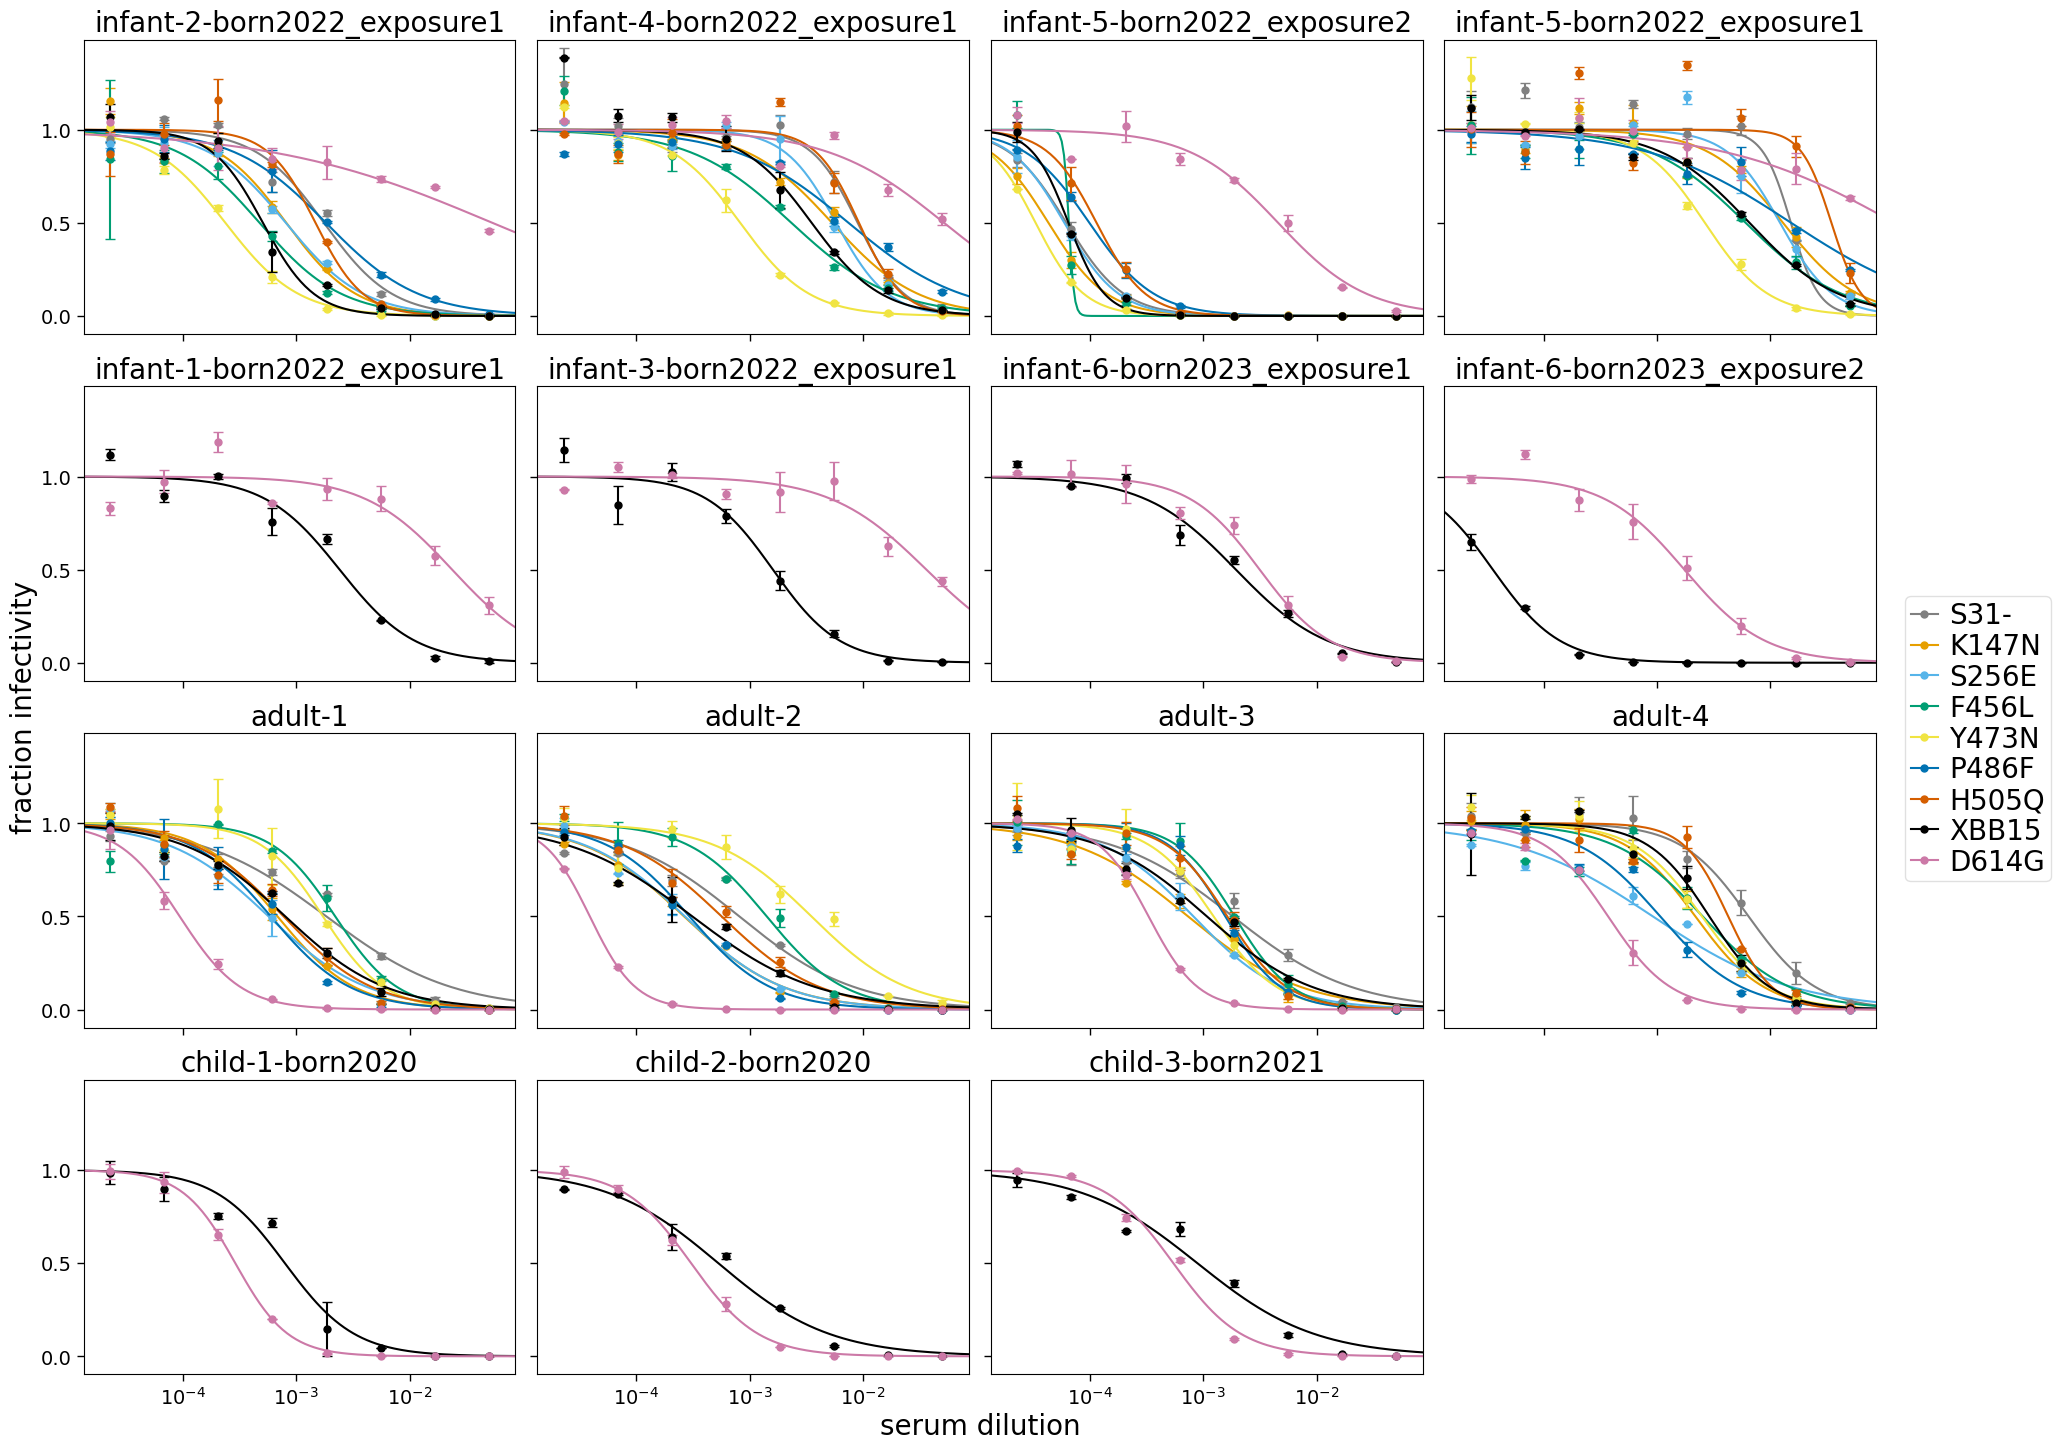

In [11]:
fig, axes = fits.plotSera(xlabel='serum dilution',
                          ncol=4,
                          widthscale=1.5,
                          heightscale=1.5,
                          titlesize=20, labelsize=20, ticksize=14,
                          legendfontsize=20, yticklocs=[0,0.5,1],
                          markersize=5, linewidth=1.5,
                          max_viruses_per_subplot = 9,
                          markers=['o','o','o','o','o','o','o', 'o', 'o'],
                          colors = color_list
                         )
plotfile_pdf = 'sera_validation_all_neuts.pdf'
plotfile_png = 'validation_all_neuts.png'
fig.savefig(f'{resultsdir}/{plotfile_pdf}', bbox_inches='tight')
fig.savefig(f'{resultsdir}/{plotfile_png}', bbox_inches='tight')

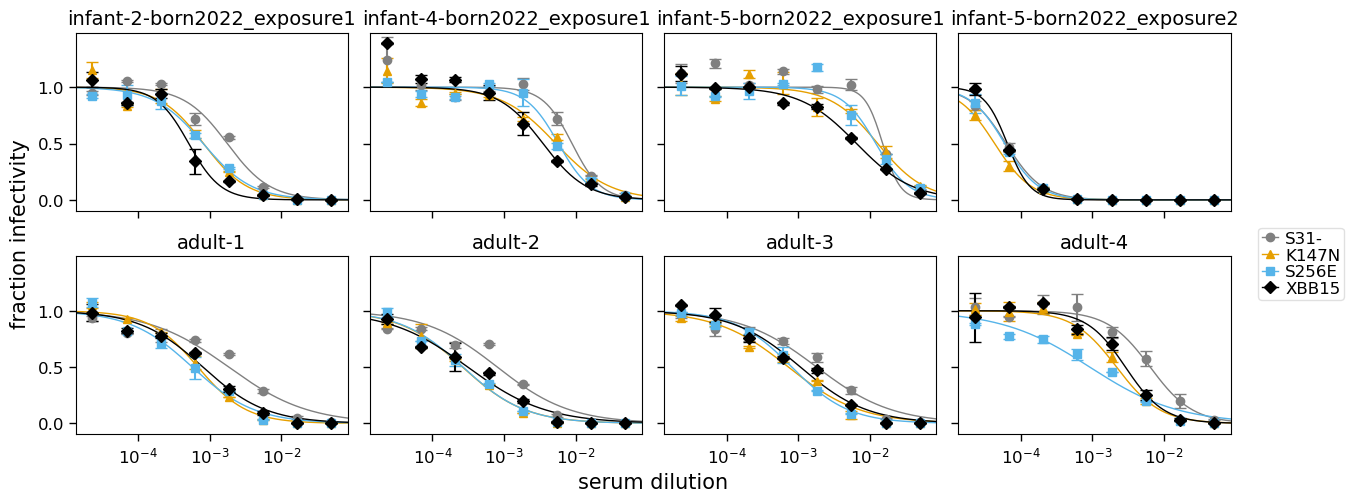

In [12]:
color_list = ['#808080', '#E69F00', '#56B4E9', '#000000']

fig, axes = fits.plotSera(xlabel='serum dilution',
                          viruses = ['S31-', 'K147N', 'S256E', 'XBB15'],
                          sera = ["infant-2-born2022_exposure1","infant-4-born2022_exposure1",
                                  "infant-5-born2022_exposure1","infant-5-born2022_exposure2",
                                 "adult-1","adult-2", "adult-3", "adult-4"],
                          ncol=4,
                          colors = color_list
                         )
plotfile_svg = 'sera_validation_NTD_neuts.svg'
plotfile_png = 'sera_validation_NTD_neuts.png'
fig.savefig(f'{resultsdir}/{plotfile_svg}', bbox_inches='tight')
fig.savefig(f'{resultsdir}/{plotfile_png}', bbox_inches='tight')

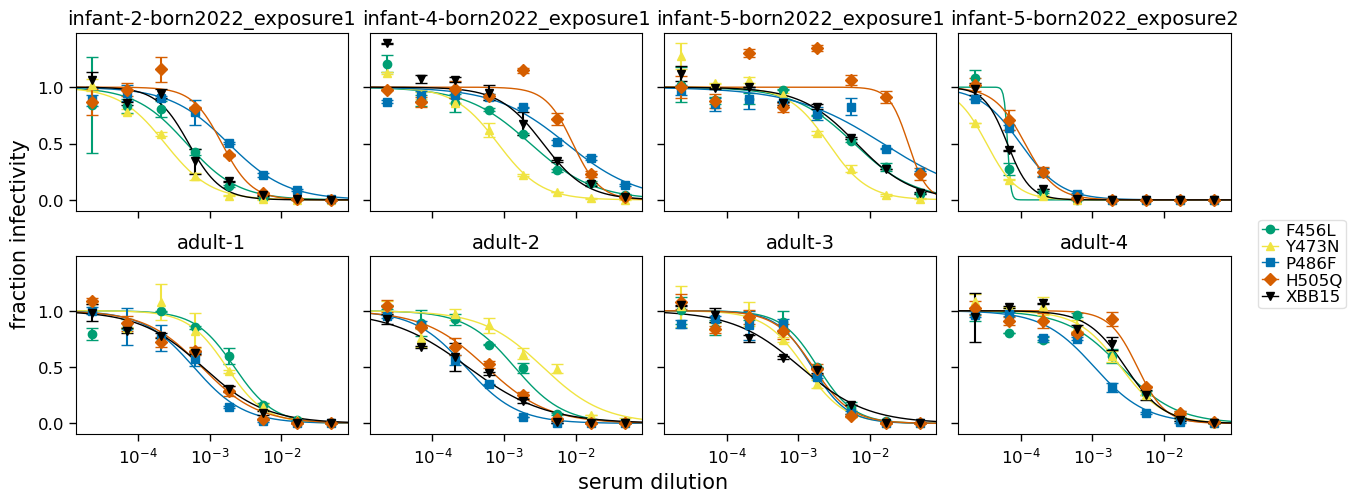

In [13]:
color_list = ['#009E73', '#F0E442', '#0072B2', '#D55E00', '#000000']

fig, axes = fits.plotSera(xlabel='serum dilution',
                          viruses = ['F456L', 'Y473N', 'P486F','H505Q','XBB15'],
                          sera = ["infant-2-born2022_exposure1","infant-4-born2022_exposure1",
                                  "infant-5-born2022_exposure1","infant-5-born2022_exposure2",
                                 "adult-1","adult-2", "adult-3", "adult-4"],
                          colors = color_list
                         )

plotfile_svg = 'sera_validation_RBD_neuts.svg'
plotfile_png = 'sera_validation_RBD_neuts.png'
fig.savefig(f'{resultsdir}/{plotfile_svg}', bbox_inches='tight')
fig.savefig(f'{resultsdir}/{plotfile_png}', bbox_inches='tight')

In [14]:
fitparams['group'] = fitparams['serum'].apply(
    lambda x: 'adult' if x.startswith('adult') 
    else 'child' if x.startswith('child') 
    else 'infant-1' if x.startswith('infant') and x.endswith('exposure1') 
    else 'infant-2' if x.startswith('infant') and x.endswith('exposure2') 
    else None
)

fitparams_WT = fitparams[fitparams['virus'].isin(['D614G', 'XBB15'])]

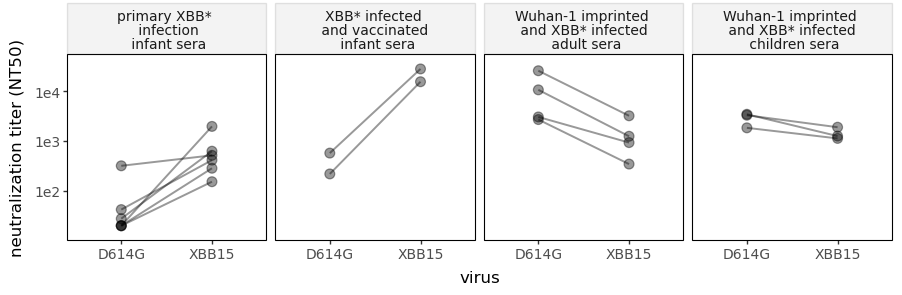

In [15]:
# Map the group labels
fitparams_WT['group_label'] = fitparams_WT['group'].map({
    'adult': 'Wuhan-1 imprinted \n and XBB* infected \n adult sera',
    'child': 'Wuhan-1 imprinted \n and XBB* infected \n children sera',
    'infant-1': 'primary XBB* \n infection\n infant sera',
    'infant-2': 'XBB* infected \n and vaccinated \n infant sera'
})

# Set the categorical order for group_label
group_label_order = [
    'primary XBB* \n infection\n infant sera',
    'XBB* infected \n and vaccinated \n infant sera',
    'Wuhan-1 imprinted \n and XBB* infected \n adult sera',
    'Wuhan-1 imprinted \n and XBB* infected \n children sera'
]
fitparams_WT['group_label'] = pd.Categorical(
    fitparams_WT['group_label'], categories=group_label_order, ordered=True
)

# Define exposure categories
fitparams_WT['exposure'] = fitparams_WT['serum'].apply(
    lambda x: 'second' if x.endswith('exposure2') else ('first' if x.endswith('exposure1') else 'multiple')
)

# Plot
NT50_faceted = (ggplot(fitparams_WT, aes(x='virus', y='NT50', group='serum')) +
                geom_point(size=3.5, alpha=0.4) +
                geom_line(size=0.8, alpha=0.4) +
                theme(
                    figure_size=(9, 3),
                    axis_text=element_text(size=10),
                    axis_text_x=element_text(size=10),
                    legend_text=element_text(size=10),
                    axis_title_x=element_text(size=12),
                    axis_title_y=element_text(size=12),
                    strip_text=element_text(size=10),
                    panel_background=element_rect(fill='white'),
                    plot_background=element_rect(fill='white'),
                    panel_border=element_line( size=0.8),
                    panel_grid_major=element_blank(),
                    panel_grid_minor=element_blank(),
                    strip_background=element_rect(colour="black", fill="#939291", alpha=0.1)
                ) +
                scale_y_log10(expand=(0.03, 0.2)) +
                ylab('neutralization titer (NT50)') +
                xlab('virus') +
                scale_color_manual(values=CBPALETTE[1:]) +
                facet_wrap('~group_label', ncol=4)
                )

# Save the plot
NT50_faceted.save("results/NT50s_faceted.svg", format="svg")
NT50_faceted.save("results/NT50s_faceted.png", format="png", dpi=300)

# Draw the plot
NT50_faceted.draw()

## Calculate fold reduction in neutralization titer

In [16]:
def calculate_nt50_change(row, df):
    # Get the NT50 value where virus is 'XBB15' for the same serum
    nt50_xbb15 = df[(df['serum'] == row['serum']) & (df['virus'] == 'XBB15')]['NT50'].values
    # Ensure that we have the value to avoid errors
    if len(nt50_xbb15) == 0 or row['NT50'] == 0:
        return None
    else:
        return nt50_xbb15[0] / row['NT50']

# Apply the calculation to the entire DataFrame
fitparams['NT50_change'] = fitparams.apply(lambda row: calculate_nt50_change(row, fitparams), axis=1)

In [17]:
fitparams['group'] = fitparams['serum'].apply(
    lambda x: 'adult' if x.startswith('adult') 
    else 'child' if x.startswith('child') 
    else 'infant-1' if x.startswith('infant') and x.endswith('exposure1') 
    else 'infant-2' if x.startswith('infant') and x.endswith('exposure2') 
    else None
)

fitparams['group_label'] = fitparams['group'].map({
    'adult': 'Wuhan-1 imprinted \n and XBB* infected \n adult sera',
    'child': 'Wuhan-1 imprinted \n and XBB* infected \n children sera',
    'infant-1': 'primary XBB* \n infection\n infant sera',
    'infant-2': 'XBB* infected \n and vaccinated \n infant sera'
})

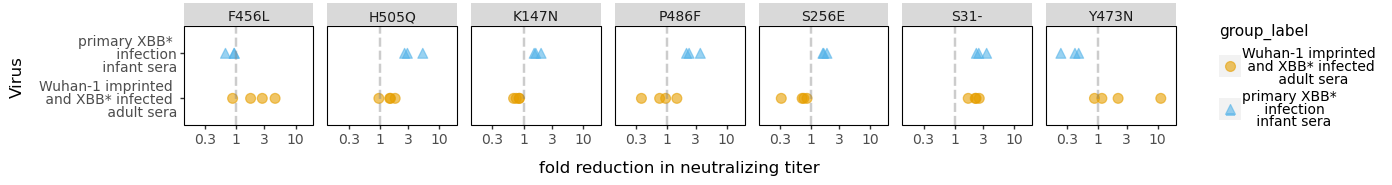

In [20]:
fitparams_compare = fitparams[fitparams['serum'].isin(["infant-2-born2022_exposure1","infant-4-born2022_exposure1",
                                  "infant-5-born2022_exposure1","infant-5-born2022_exposure2",
                                 "adult-1","adult-2", "adult-3", "adult-4"])]

fitparams_all = fitparams_compare[fitparams_compare['virus'].isin(['S31-', 'K147N', 'S256E','F456L', 'Y473N', 'P486F','H505Q',])]

fitparams_all = fitparams_all[fitparams_all['group_label'] != 'XBB* infected \n and vaccinated \n infant sera']

NT50_change = (ggplot(fitparams_all, aes(x='NT50_change', y='group_label', group='group_label', color='group_label', shape='group_label')) +
              geom_point(size=3.5, alpha=0.6) +
              theme(
                   figure_size=(14,2),
                   axis_text=element_text(size=10),
                   axis_text_y=element_text(size=10, angle=0),
                   legend_text=element_text(size=10),
                   axis_title_x=element_text(size=12),
                   axis_title_y=element_text(size=12),
                   strip_text=element_text(size=10),
                   panel_background=element_rect(fill='white'),
                   plot_background=element_rect(fill='white'),
                   panel_border=element_line(size=0.8),
                   panel_grid_major=element_blank(),  # Remove major grid lines
                   panel_grid_minor=element_blank()
                  ) +
              geom_vline(xintercept=1, color='grey', linetype='dashed', size=1, alpha=0.4) +
              scale_x_log10(expand=(0.03, 0.2)) +
              ylab('Virus') +
              xlab('fold reduction in neutralizing titer') +
              facet_wrap('~virus', ncol=7) +
              scale_color_manual(values=CBPALETTE[1:])
          )
NT50_change.save("results/NT50_change_flipped.svg", format="svg")
NT50_change.save("results/NT50_change_flipped.png", format="png", dpi=300)
NT50_change.draw()